In [1]:
data_path = "/scratch/cl6707/Shared_Datasets/NSD_MindEye"
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
subj = 1
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)
from src.file_utility import load_mask_from_nii, view_data

%matplotlib inline
fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import load_mask_from_nii
from nilearn.decoding import SpaceNetRegressor
import nibabel as nib

subj =1
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subj)
voxel_roi_full.shape

# from NSDAccess import NSDAccess
# nsd = NSDAccess('/scratch/cl6707/Projects/neuro_interp/data/NSD/')

if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
    
    
print('Pulling NSD webdataset data...')
# Multi-GPU config #
from accelerate import Accelerator
accelerator = Accelerator(split_batches=False,mixed_precision='fp16')  
print("PID of this process =",os.getpid())
print = accelerator.print # only print if local_rank=0
device = accelerator.device
print("device:",device)
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices
print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)



train_url = "{" + f"{data_path}/webdataset_avg_split/train/train_subj0{subj}_" + "{0..17}.tar," + f"{data_path}/webdataset_avg_split/val/val_subj0{subj}_0.tar" + "}"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
print(train_url,"\n",val_url)
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = 1
print('Prepping train and validation dataloaders...')

train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,'images',
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    num_train=num_train,
    num_val=num_val,
    val_batch_size=1,
    cache_dir=data_path, #"/tmp/wds-cache",
    seed=seed,
    voxels_key='nsdgeneral.npy', # 'nsdgeneral.npy' (1d), 'wholebrain_3d.npy'(3d)
    to_tuple=["voxels", "images", "coco","trial"],
    local_rank=local_rank,
    world_size=world_size,
)

device: cpu


2023-12-18 23:20:11.767607: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 23:20:12.806333: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 23:20:13.292650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 23:20:13.292678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 23:20:13.303250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Pulling NSD webdataset data...
PID of this process = 1062501
device: cpu
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cpu

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1
{/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/train/train_subj01_{0..17}.tar,/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/val/val_subj01_0.tar} 
 /scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/test/test_subj01_{0..1}.tar
Prepping train and validation dataloaders...
Getting dataloaders...

num_train 8859
global_batch_size 1
batch_size 1
num_workers 1
num_batches 8859
num_worker_batches 8859

num_val 982
val_num_batches 982
val_batch_size 1


In [2]:
from nilearn.decoding import SpaceNetClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_curve, auc
nsd_mindroot = '/scratch/cl6707/Shared_Datasets/NSD_MindEye'

things = np.load(nsd_mindroot + '/subj%02d_things.npy'%subj,allow_pickle=True)
things_all = np.concatenate(things, axis=0)
unique_things = np.unique(things_all)
things_val_mapping = {k:i for i,k in enumerate(unique_things)}
val_things_mapping = {i:k for i,k in enumerate(unique_things)}

import plotly.graph_objects as go
from sklearn.preprocessing import label_binarize
def plot_roc_curve(y_true, y_pred, unique_things, title):
    y_true = label_binarize(y_true, classes=np.arange(0, len(unique_things)))
    y_pred = label_binarize(y_pred, classes=np.arange(0, len(unique_things)))
    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Create a Plotly figure
    fig = go.Figure()

    # Add ROC curve traces for each class
    for i in range(n_classes):
        fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'{unique_things[i]} (AUC = {roc_auc[i]:.2f})'))

    # Add a diagonal line for a no-skill classifier
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='No Skill', line=dict(dash='dash')))

    # Update the layout
    fig.update_layout(
        title=title,
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        legend_title='Classes',
        # legend=dict(y=0.5, x=0.85),
        # margin=dict(l=40, r=40, t=40, b=40),
        width=800,height=800
    )

    # Show the figure
    fig.show()

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()   
    
nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine
nsdgeneral =  nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz')
nsdgeneral_roi_mask = (nsdgeneral.get_fdata()==1).astype(np.float32)
nsdgeneral = nib.Nifti1Image(nsdgeneral_roi_mask, nsdgeneral_affine)
anat_img = '/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/T1_to_func1pt8mm.nii.gz'

def reconstruct_volume_corrected(vol_shape, binary_mask, data_vol, order='C'):
    
    view_vol = np.ones(np.prod(vol_shape), dtype=np.float32) * np.nan
    
    idx_mask = np.where(binary_mask)[0]
    
    view_vol[idx_mask] = data_vol
    return np.nan_to_num(view_vol.reshape(vol_shape, order=order))

In [3]:
X_train_all = []
y_train_all = []
X_val_all = []
y_val_all = []
# get all the data:

train_iter = iter(train_dl)
test_iter = iter(val_dl)

for i in tqdm(range(num_train)):
    voxels, _, _, trial = next(train_iter)
    voxels = voxels[0].cpu().numpy().mean(axis=0)
    # convert voxels to 3d volume
    voxels = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxels)
    nii_voxels = nib.Nifti1Image(voxels, nsdgeneral_affine)
    labels = things[trial]
    # for label in labels:
    #     X_train_all.append(nii_voxels)
    #     y_train_all.append(things_val_mapping[label])
    if len(labels)>=1 and len(labels)<=3:
        X_train_all.append(nii_voxels)
        y_train_all.append(things_val_mapping[labels[0]])

for i in tqdm(range(num_val)):
    voxels, _, _, trial = next(test_iter)
    voxels = voxels[0].cpu().numpy().mean(axis=0)
    # convert voxels to 3d volume
    voxels = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxels)
    nii_voxels = nib.Nifti1Image(voxels, nsdgeneral_affine)
    labels = things[trial]
    # for label in labels:
    #     X_val_all.append(nii_voxels)
    #     y_val_all.append(things_val_mapping[label])
    if len(labels)>=1 and len(labels)<=3:
        X_val_all.append(nii_voxels)
        y_val_all.append(things_val_mapping[labels[0]])

print('Saving all the data...')
print('len(X_train_all):',len(X_train_all), 'len(y_train_all):',len(y_train_all))
print('len(X_val_all):',len(X_val_all), 'len(y_val_all):',len(y_val_all))


  0%|          | 0/8859 [00:00<?, ?it/s]

  0%|          | 0/982 [00:00<?, ?it/s]

Saving all the data...
len(X_train_all): 7675 len(y_train_all): 7675
len(X_val_all): 887 len(y_val_all): 887


## Train the base classifier model

In [10]:

decoder = SpaceNetClassifier(
    mask = nsdgeneral,
    memory = 'nilearn_cache',
    penalty='graph-net',
    screening_percentile=5.0,
    memory_level=2,
    standardize="zscore_sample",
)

decoder.fit(X_train_all, y_train_all)
import pickle
pickle.dump(decoder, open('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/decoder.pkl', 'wb'))

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(81, 104, 83, 7715),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/ext3/miniconda3/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:558: UserWarning: Persisting input arguments took 66.21s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 625.2s, 10.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 615.2s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 615.4s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 629.7s, 10.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 613.1s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 620.5s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 619.7s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 627.3s, 10.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 625.1s, 10.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 619.3s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.94s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 616.9s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 614.1s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 613.1s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 613.8s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 610.9s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 616.9s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 613.5s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 614.4s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 607.2s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 604.3s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 604.9s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 5.93s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 612.7s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 609.9s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.42s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 615.2s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.42s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 622.0s, 10.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 628.1s, 10.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 614.8s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 611.0s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 614.8s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 611.9s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 611.4s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 615.0s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 614.2s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 611.6s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 605.1s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 604.6s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 598.5s, 10.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 599.5s, 10.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 607.9s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 411.2min


___________________________________________________path_scores - 603.8s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 622.7s, 10.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 620.0s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 606.2s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 619.7s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 620.8s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 616.8s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 627.4s, 10.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 629.4s, 10.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 607.8s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 616.9s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 609.6s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 617.5s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 609.1s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 612.4s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 616.5s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 622.5s, 10.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 604.9s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 6.68s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 609.8s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 6.66s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 622.1s, 10.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 6.73s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 613.2s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 6.04s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 619.9s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 609.8s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 605.5s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 592.3s, 9.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 611.7s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 607.7s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 601.0s, 10.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 604.6s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 608.6s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.42s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 597.3s, 10.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 600.1s, 10.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 613.9s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 610.2s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 602.5s, 10.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 596.8s, 9.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 609.5s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 612.3s, 10.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 5.87s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 617.3s, 10.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 5.48s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 621.2s, 10.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 5.37s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 627.0s, 10.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 457, ..., 7714]), array([   0, ..., 1176]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 605.8s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([ 457, ..., 2119]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 595.3s, 9.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([1733, ..., 3095]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 595.1s, 9.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([2538, ..., 4000]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 595.2s, 9.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([3615, ..., 4987]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 603.3s, 10.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([4602, ..., 5939]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.40s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


___________________________________________________path_scores - 600.0s, 10.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7714]), array([5122, ..., 6942]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.41s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 592.9s, 9.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7a10c509d0>, array([[-1.896135, ..., -1.620179],
       ...,
       [ 0.370344, ..., -0.863363]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 6942]), array([6311, ..., 7714]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


In [4]:
# save the model
# import pickle
# pickle.dump(decoder, open('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/decoder.pkl', 'wb'))

# load the model
import pickle
decoder = pickle.load(open('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/decoder.pkl', 'rb'))
y_val_pred = decoder.predict(X_val_all)
y_train_pred = decoder.predict(X_train_all)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(81, 104, 83, 7675),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/ext3/miniconda3/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:558: UserWarning: Persisting input arguments took 68.85s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


In [6]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
# save accuracy scores, f1 scores,  recall scores, precision scores, confusion matrix, roc curve
accuracy_test = accuracy_score(y_val_all, y_val_pred)
accuracy_train = accuracy_score(y_train_all, y_train_pred)
print('Accuracy test:', accuracy_test)
print('Accuracy train:', accuracy_train)
f1_test = f1_score(y_val_all,y_val_pred , average='weighted')
f1_train = f1_score(y_train_all, y_train_pred, average='weighted')
print('F1 test:', f1_test)
print('F1 train:', f1_train)
recall_test = recall_score(y_val_all, y_val_pred, average='weighted')
recall_train = recall_score(y_train_all, y_train_pred, average='weighted')
print('Recall test:', recall_test)
print('Recall train:', recall_train)
precision_test = precision_score(y_val_all, y_val_pred, average='weighted')
precision_train = precision_score(y_train_all, y_train_pred, average='weighted')
print('Precision test:', precision_test)
print('Precision train:', precision_train)
df_metric = pd.DataFrame({'accuracy':[accuracy_test, accuracy_train], 'f1':[f1_test, f1_train], 'recall':[recall_test, recall_train], 'precision':[precision_test, precision_train]}, index=['test', 'train'])
df_metric.to_csv(os.path.join("/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/",f'metrics_baseline.csv'))


Accuracy test: 0.5839909808342728
Accuracy train: 0.7198697068403909
F1 test: 0.6038996732041807
F1 train: 0.7412973085477367
Recall test: 0.5839909808342728
Recall train: 0.7198697068403909
Precision test: 0.6956380446944759
Precision train: 0.8128813346345678


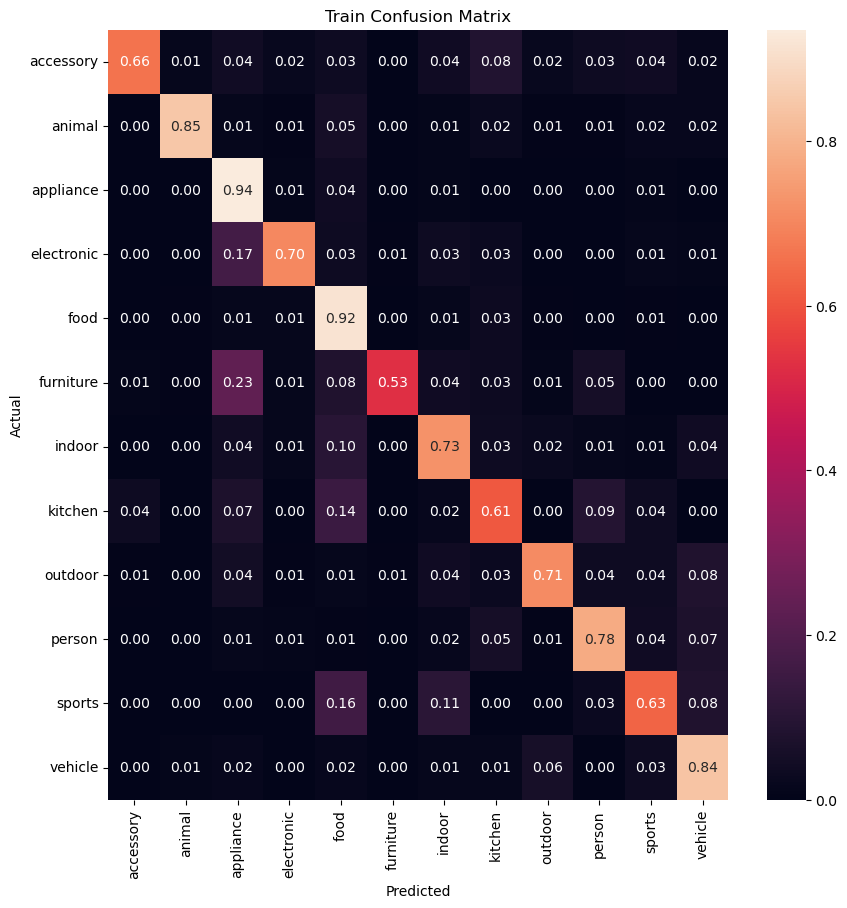

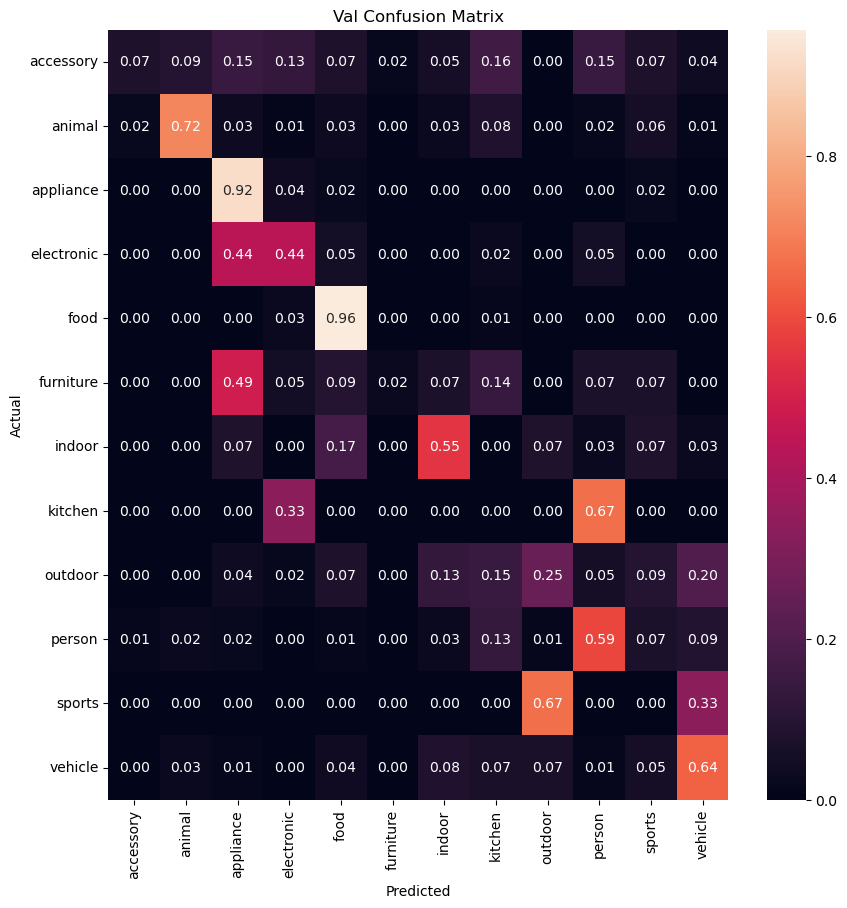

,accuracy,f1,precision,recall
train,0.779326,0.666751,0.682506,0.740464
val,0.583991,0.408426,0.473418,0.430229


In [5]:
# plot confusion matrix
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns



plot_confusion_matrix(y_train_all, y_train_pred, unique_things, 'Train Confusion Matrix')
plot_confusion_matrix(y_val_all, y_val_pred, unique_things, 'Val Confusion Matrix')
metrics_df = {
    'accuracy': [accuracy_score(y_train_all, y_train_pred), accuracy_score(y_val_all, y_val_pred)],
    'f1': [f1_score(y_train_all, y_train_pred, average='macro'), f1_score(y_val_all, y_val_pred, average='macro')],
    'precision': [precision_score(y_train_all, y_train_pred, average='macro'), precision_score(y_val_all, y_val_pred, average='macro')],
    'recall': [recall_score(y_train_all, y_train_pred, average='macro'), recall_score(y_val_all, y_val_pred, average='macro')]
}
metrics_df = pd.DataFrame(metrics_df, index=['train', 'val'])
metrics_df



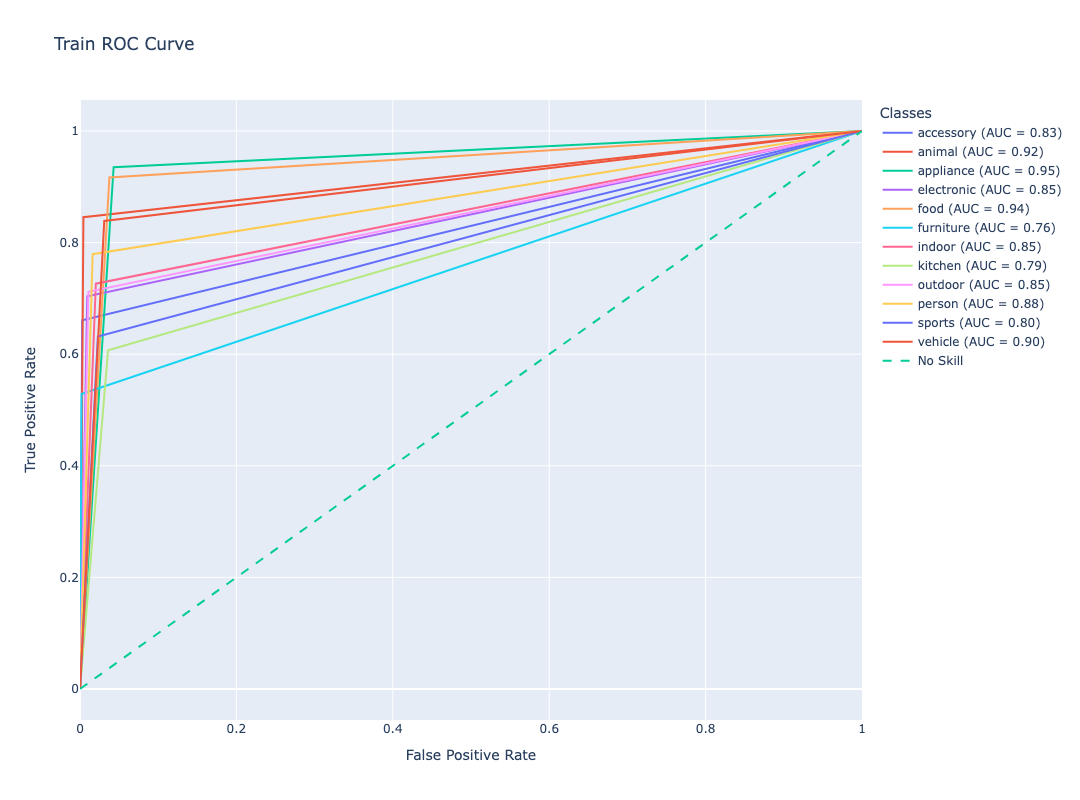

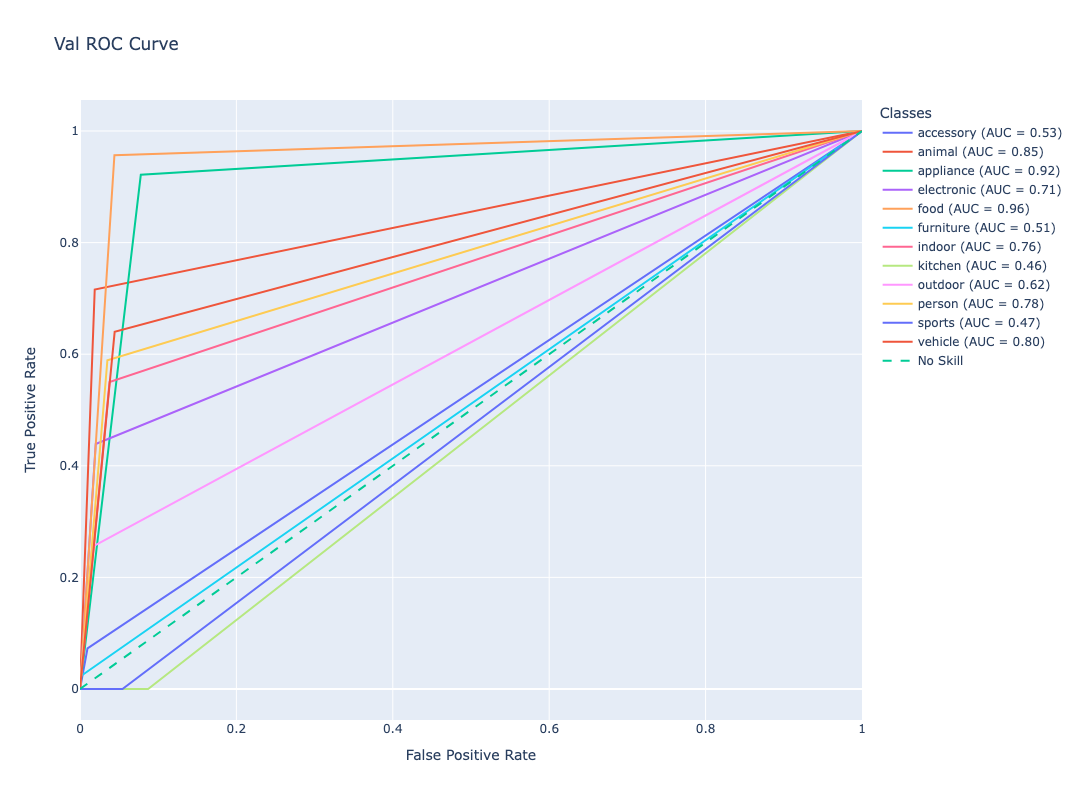

In [8]:

    
plot_roc_curve(y_train_all, y_train_pred, unique_things, 'Train ROC Curve')
plot_roc_curve(y_val_all, y_val_pred, unique_things, 'Val ROC Curve')

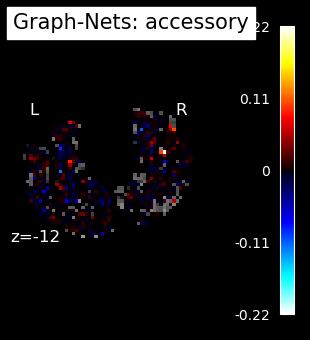

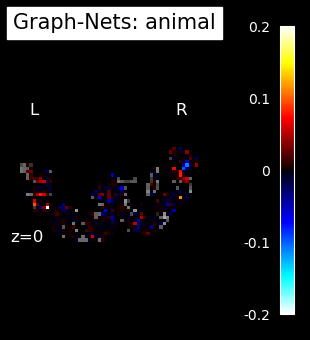

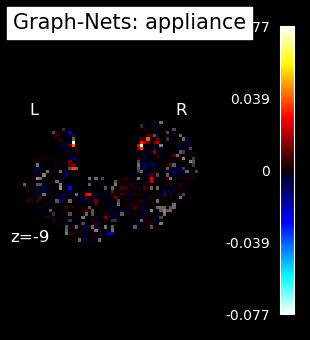

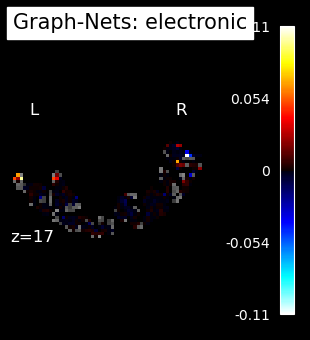

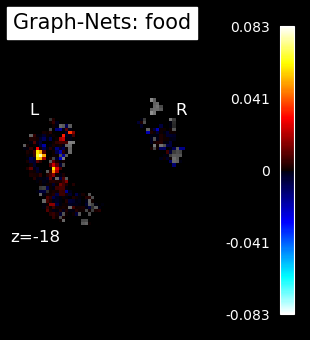

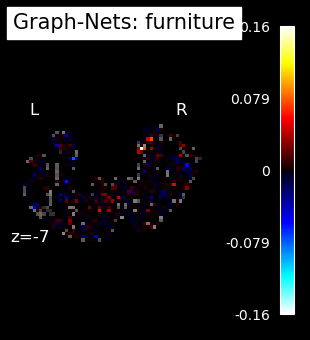

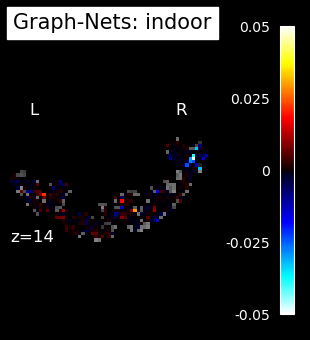

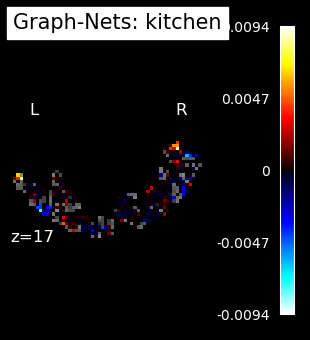

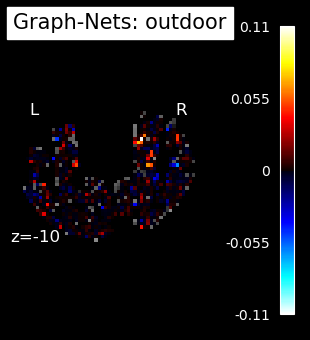

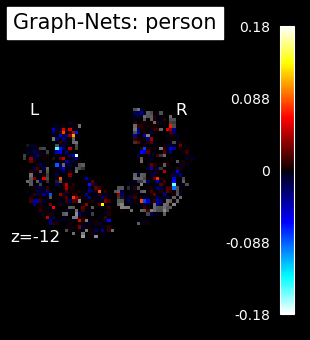

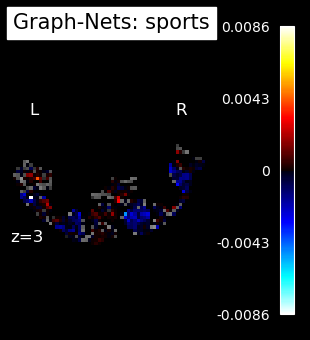

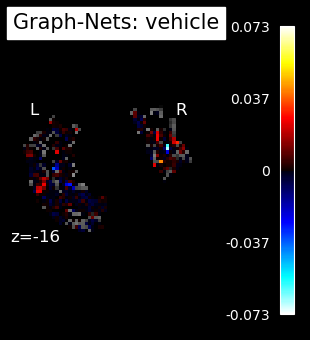

In [12]:
# plot spacenet weights
from nilearn.plotting import plot_stat_map, show
from nilearn.image import index_img
coefficients_img = decoder.coef_img_
background_img = X_val_all[0]
for i in range(12):
    coef_img_3d = index_img(coefficients_img, i)
    plot_stat_map(coef_img_3d, 
                  bg_img = background_img,
                    display_mode='z',
                    cut_coords=1,
                    title = f"Graph-Nets: {val_things_mapping[i]}"
                  )
    # save the plot
    plt.savefig(f'/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/subj{subj}_spacenet_{val_things_mapping[i]}.png')
    # Display the plot
    show()


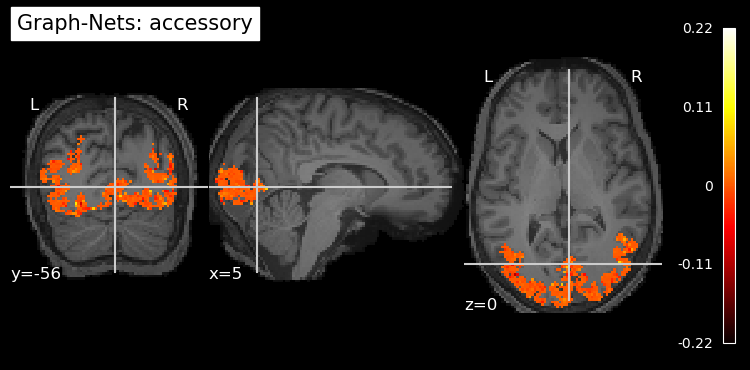

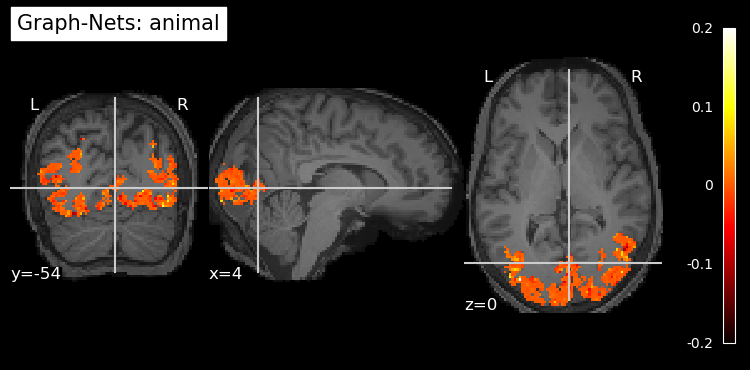

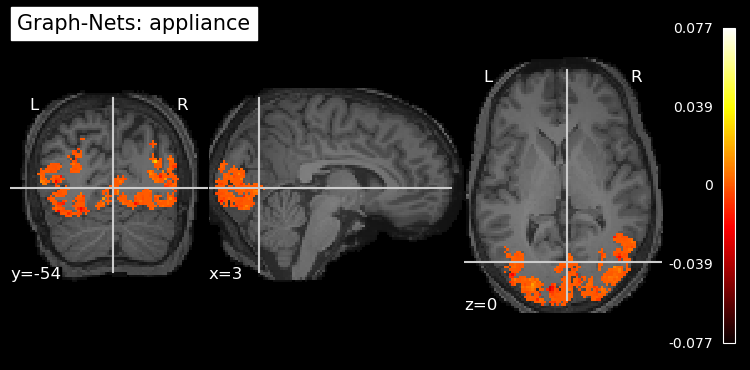

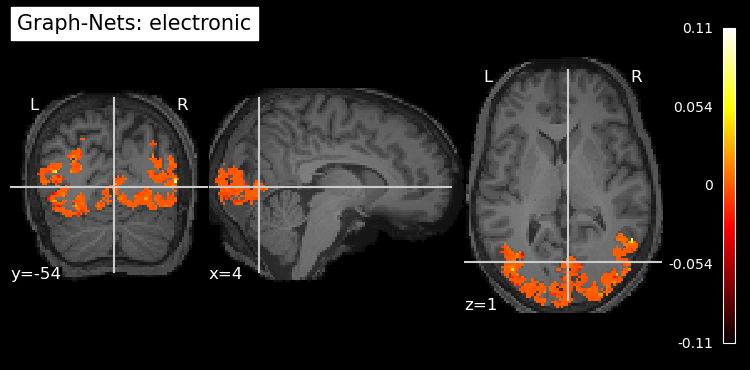

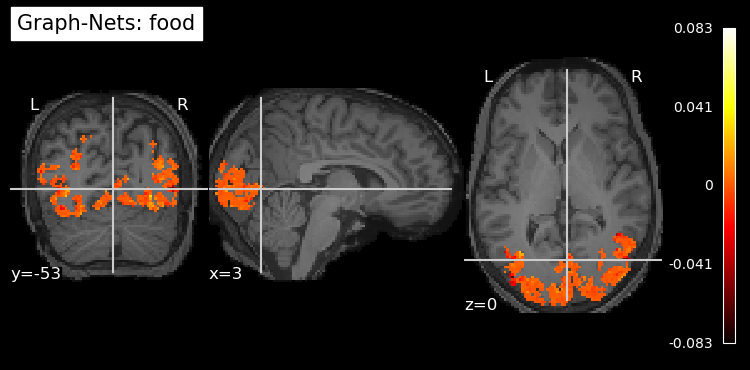

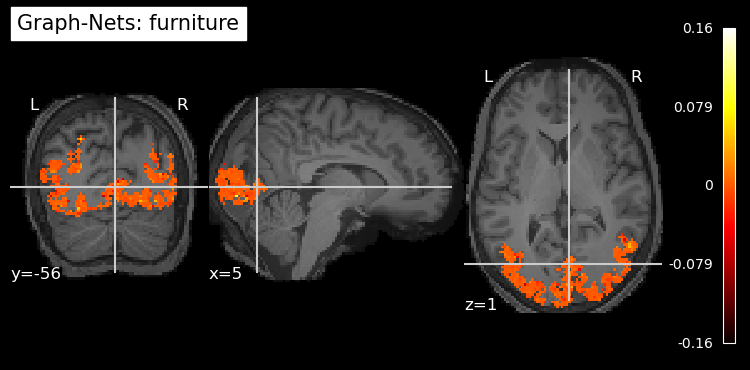

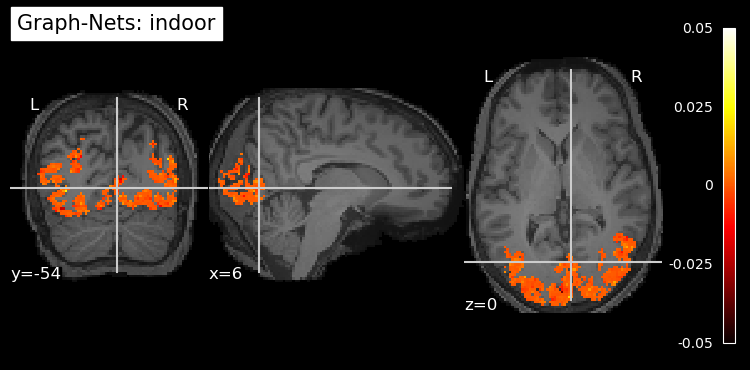

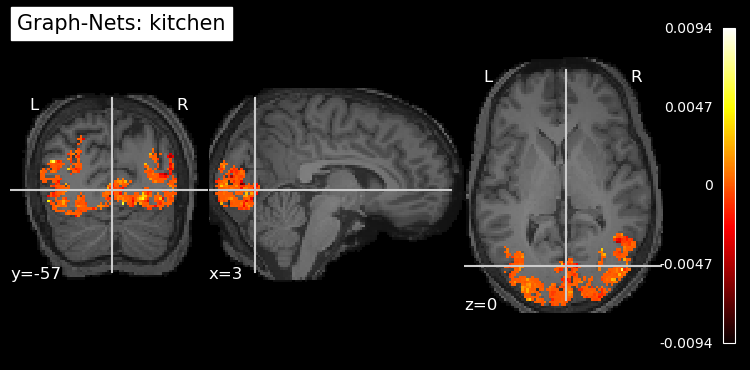

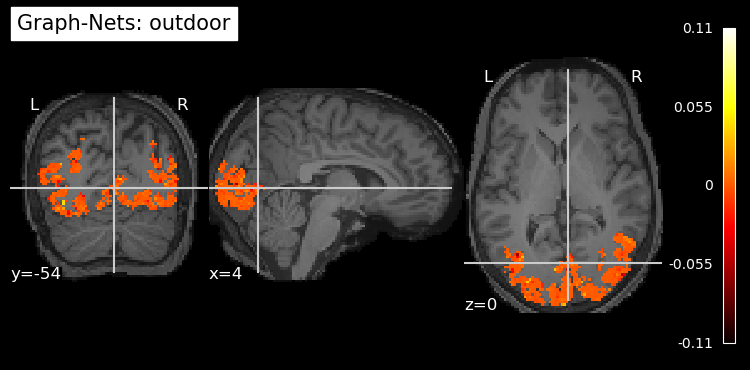

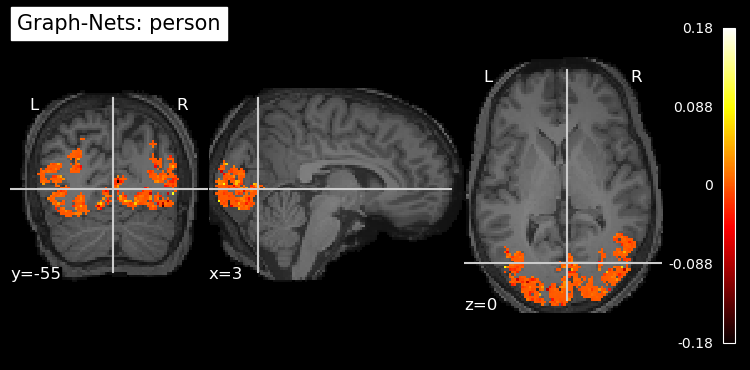

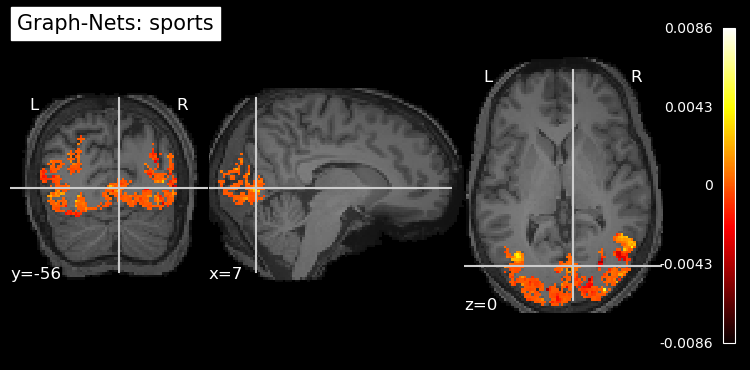

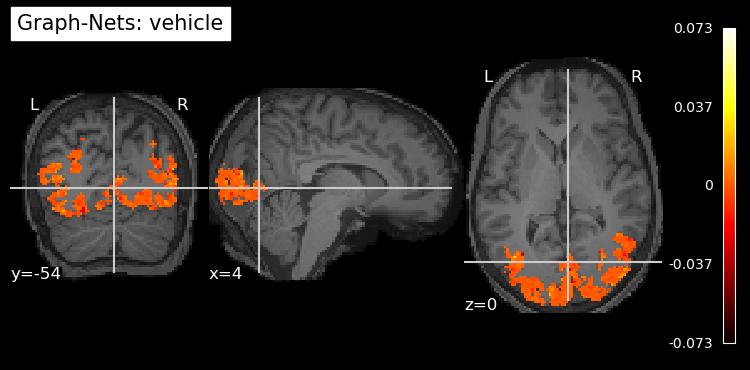

In [13]:
for i in range(12):
    plot_stat_map(index_img(coefficients_img,i), bg_img=anat_img,
                cmap = 'hot',
                title = f"Graph-Nets: {val_things_mapping[i]}",
                )
    show()

## Get weights from PCA regression model to mask out corresponding voxels in the brain

### load data

In [35]:
from nilearn.masking import intersect_masks
from nilearn.image import index_img
import h5py
def load_coef_images(base_path, num_images):
    images = []
    for i in range(num_images):
        path = os.path.join(base_path, f'coef_img_{i}.nii.gz')
        img = nib.load(path).get_fdata()
        images.append(img)
    return images

def create_intersection_masks(coef_images, affine, num_thresholds=9, start=0.1, stop=0.15, intersection_threshold=0.5):
    mask_by_threshold = {}
    thresholds = np.arange(start, stop, (stop - start) / num_thresholds)
    mask_voxels = 0
    for threshold in tqdm(thresholds):
        mask_list = []
        for img in coef_images:
            img = img.copy()[:,:,:,0]
            img = np.abs(img)
            # keep top t*num_of_nonzero_voxels
            t = np.percentile(img[img>0], threshold*100)
            mask = (img >t).astype(float)
            nifti_mask = nib.Nifti1Image(mask, affine)
            mask_list.append(nifti_mask)
        intersection_mask = intersect_masks(mask_list, threshold=intersection_threshold, connected=True)
        if intersection_mask.get_fdata().sum() != mask_voxels:
            mask_voxels = intersection_mask.get_fdata().sum()
            mask_by_threshold[mask_voxels] = intersection_mask
            print(f'intersection mask voxels: {mask_voxels}')
        else:
            continue  
    return mask_by_threshold
# if os.path.exists('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/masks.h5'):
#     # load masks
#     masks = {}
#     with h5py.File('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/masks.h5', 'r') as hf:
#         for key in hf.keys():
#             masks[key] = hf[key][:]
# else:
    # Usage
base_path = '/scratch/ne2213/projects/IVP/Neural_Interpretation-main/notebooks/coef_images'
num_images = 50  # or dynamically determine this
coef_images = load_coef_images(base_path, num_images)
masks = create_intersection_masks(coef_images, nsdgeneral_affine,num_thresholds=20,start=0, stop=1.0, intersection_threshold=0.2)
# save masks with h5py
with h5py.File('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/masks.h5', 'w') as hf:
    for key in masks.keys():
        hf.create_dataset(str(key), data=masks[key].get_fdata())


  0%|          | 0/20 [00:00<?, ?it/s]

intersection mask voxels: 13057.0
intersection mask voxels: 13055.0
intersection mask voxels: 13042.0
intersection mask voxels: 12993.0
intersection mask voxels: 12887.0
intersection mask voxels: 12688.0
intersection mask voxels: 12300.0
intersection mask voxels: 11565.0
intersection mask voxels: 10280.0
intersection mask voxels: 7831.0
intersection mask voxels: 2425.0
intersection mask voxels: 40.0
intersection mask voxels: 5.0
intersection mask voxels: 1.0


In [4]:
import h5py
# load masks with h5py
masks = {}
with h5py.File('/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/masks.h5', 'r') as hf:
    for key in hf.keys():
        masks[key] = nib.Nifti1Image(hf[key][:], nsdgeneral_affine)

In [36]:
from nilearn.plotting import plot_stat_map, show
for threshold in masks.keys():
    # plot_stat_map(masks[threshold], bg_img=anat_img,
    #             cmap = 'hot',
    #             title = f"Graph-Nets: {threshold}",
    #             )
    # show()
    print(masks[threshold].get_fdata().sum())

13057.0
13055.0
13042.0
12993.0
12887.0
12688.0
12300.0
11565.0
10280.0
7831.0
2425.0
40.0
5.0
1.0


## train N models

In [37]:
for threshold, mask in tqdm(masks.items()):
   model = SpaceNetClassifier(
        mask=mask,
        memory = 'nilearn_cache',
        penalty='graph-net',
        screening_percentile=5.0,
        memory_level=2,
        standardize="zscore_sample",
     )
   model.fit(X_train_all, y_train_all)
   pickle.dump(model, open(f'/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/decoder_by_threshold_{threshold}.pkl', 'wb'))
   print('threshold:',threshold,'decoder saved')

  0%|          | 0/14 [00:00<?, ?it/s]

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(81, 104, 83, 7686),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/ext3/miniconda3/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:558: UserWarning: Persisting input arguments took 68.74s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 433.1s, 7.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1, screening_percentile=100.0)


....../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 423.5s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 2), debias=False, verbose=1, screening_percentile=100.0)


....../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 429.4s, 7.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 3), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 425.6s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 4), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 421.2s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 5), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 418.6s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 6), debias=False, verbose=1, screening_percentile=100.0)


....../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 426.7s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 7), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 421.0s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 420.6s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 1), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 427.3s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 2), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 421.1s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 3), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 423.3s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 4), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 417.2s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 5), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 419.4s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 6), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 423.4s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 7), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 423.5s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 416.8s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 1), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 421.1s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 2), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 411.3s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 3), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 407.8s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 4), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 407.3s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 5), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 412.1s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 6), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 408.2s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 7), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 410.4s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 412.2s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 1), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 417.5s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 2), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 417.8s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 3), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 421.3s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 4), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 416.3s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 5), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 416.0s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 6), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 416.6s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 7), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 418.8s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 0), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 407.2s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 1), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 409.4s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 2), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 410.0s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 3), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 407.9s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 4), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 404.8s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 5), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 407.7s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 6), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 415.1s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 7), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 279.5min


____________________________________________________path_scores - 407.5s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 417.4s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 1), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 422.3s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 2), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 427.2s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 3), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 423.4s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 4), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 418.7s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 5), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 418.7s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 6), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 425.3s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 7), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 416.8s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 420.1s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 1), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 423.1s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 2), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 416.3s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 3), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 413.6s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 4), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 412.0s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 5), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 410.3s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 6), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 418.3s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(6, 7), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 413.7s, 6.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 407.6s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 1), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 404.4s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 2), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 406.6s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 3), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 399.8s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 4), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 407.5s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 5), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 405.7s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 6), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 404.6s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(7, 7), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 404.5s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 424.6s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 1), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 423.5s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 2), debias=False, verbose=1, screening_percentile=100.0)


......./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 8.14s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 445.3s, 7.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 3), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 430.5s, 7.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 4), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 420.6s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 5), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 406.6s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 6), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 420.6s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(8, 7), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 422.9s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 0), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 421.5s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 1), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 426.8s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 2), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 427.7s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 3), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 429.2s, 7.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 4), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 419.1s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 5), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 420.5s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 6), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 423.8s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(9, 7), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 428.5s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 0), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 399.8s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 1), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 400.1s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 2), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 404.4s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 3), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 400.1s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([3681, ..., 5245]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 4), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 393.6s, 6.6min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([4712, ..., 6291]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 5), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 400.3s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([5490, ..., 7172]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 6), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 406.5s, 6.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7172]), array([6504, ..., 7685]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(10, 7), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 399.7s, 6.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 882, ..., 7685]), array([   0, ..., 1524]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 0), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.19s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 422.2s, 7.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([ 882, ..., 2031]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 1), debias=False, verbose=1, screening_percentile=100.0)


........./ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.16s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 426.7s, 7.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([1805, ..., 2992]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 2), debias=False, verbose=1, screening_percentile=100.0)


......../ext3/miniconda3/lib/python3.10/site-packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.17s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 469.5s, 7.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f17513c49d0>, array([[-1.358223, ..., -0.183017],
       ...,
       [-1.12612 , ..., -1.966346]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7685]), array([2776, ..., 4162]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(11, 3), debias=False, verbose=1, screening_percentile=100.0)


.

In [8]:
pickle.dump(model, open(f'/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/output/brain_decoding/decoder_by_threshold_{threshold}.pkl', 'wb'))